# Tutorial

In [ ]:
https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/Miczone/idcard_segmentation

/content/drive/.shortcut-targets-by-id/1msApnOm2ncfh6tKyymQQXRhy94uIkWCa/Miczone/idcard_segmentation


In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

# Data

In [ ]:
!unzip "/content/drive/MyDrive/Miczone/idcard_segmentation/data_0606.zip" -d "/content/drive/MyDrive/Miczone/idcard_segmentation/"

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultPredictor, DefaultTrainer
import torch, torchvision
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
import copy

def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((640,640)),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [4]:
# from detectron2.data.datasets import register_coco_instances
# from detectron2.data import MetadataCatalog, DatasetCatalog
# # datasets' unique names to register

# data_path = '/content/drive/MyDrive/Miczone/idcard_segmentation/data_0606'
# train_name ="idcard_train"
# test_name = "idcard_valid"

# image_root = f"{data_path}/images"
# train_instances = f"{data_path}/train/_annotations.coco.json"
# test_instances = f"{data_path}/valid/_annotations.coco.json"

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
# datasets' unique names to register

data_path = '/content/drive/MyDrive/Miczone/idcard_segmentation/data_0606'
train_name ="idcard_train"
test_name = "idcard_valid"

image_root = "/content/drive/MyDrive/Miczone/idcard_segmentation/data_0606"
train_instances = "/content/drive/MyDrive/Miczone/idcard_segmentation/annotation_0606/data/train.json"
test_instances = "/content/drive/MyDrive/Miczone/idcard_segmentation/annotation_0606/data/val.json"

In [4]:
register_coco_instances(train_name, {}, train_instances, image_root)
register_coco_instances(test_name, {}, test_instances, image_root)

meta_train = MetadataCatalog.get(train_name)
data_train = DatasetCatalog.get(train_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



# Train

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [7]:
# set hyper parameters
cfg = get_cfg()

# cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file("detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (train_name,)
cfg.DATASETS.TEST = (test_name,)  

# cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "weights/resnext101"
cfg.INPUT.MASK_FORMAT = 'bitmask'
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AugTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 09:28:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[06/06 09:28:37 d2.engine.train_loop]: Starting training from iteration 0
[06/06 09:28:52 d2.utils.events]:  eta: 0:45:26  iter: 19  total_loss: 1.999  loss_cls: 0.623  loss_box_reg: 0.003288  loss_mask: 0.6931  loss_rpn_cls: 0.6578  loss_rpn_loc: 0.01074  time: 0.6884  data_time: 0.2524  lr: 1.9981e-06  max_mem: 4455M
[06/06 09:29:05 d2.utils.events]:  eta: 0:44:36  iter: 39  total_loss: 1.83  loss_cls: 0.4688  loss_box_reg: 0.003545  loss_mask: 0.6895  loss_rpn_cls: 0.6566  loss_rpn_loc: 0.009201  time: 0.6520  data_time: 0.1033  lr: 3.9961e-06  max_mem: 4455M
[06/06 09:29:17 d2.utils.events]:  eta: 0:43:50  iter: 59  total_loss: 1.664  loss_cls: 0.318  loss_box_reg: 0.002664  loss_mask: 0.6826  loss_rpn_cls: 0.6511  loss_rpn_loc: 0.0109  time: 0.6403  data_time: 0.1086  lr: 5.9941e-06  max_mem: 4455M
[06/06 09:29:28 d2.utils.events]:  eta: 0:43:41  iter: 79  total_loss: 1.539  loss_cls: 0.212  loss_box_reg: 0.002986  loss_mask: 0.6709  loss_rpn_cls: 0.6461  loss_rpn_loc: 0.01136  ti

# Test

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.model_zoo import *

# set config
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file("detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (train_name,)
cfg.DATASETS.TEST = (test_name,)   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "weights/resnext101"
cfg.INPUT.MASK_FORMAT = 'bitmask'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(data_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

In [10]:
from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(test_name, cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, test_name)
inference_on_dataset(trainer.model, test_loader, evaluator)

[06/06 10:17:15 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

OrderedDict([('bbox',
              {'AP': 86.5714195226877,
               'AP50': 99.92758528777634,
               'AP75': 98.96533820926192,
               'APl': 86.5714195226877,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 90.2642561080195,
               'AP50': 99.92758528777634,
               'AP75': 98.97426552398179,
               'APl': 90.2642561080195,
               'APm': nan,
               'APs': nan})])

# Display predict label

WARNING [06/06 06:48:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 06:48:30 d2.data.datasets.coco]: Loaded 8 images in COCO format from /data_science/data_science/data/v1/idcard/segmentation/idcard_coco_segmentation/valid/_annotations.coco.json


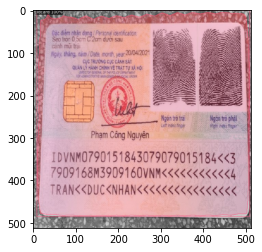

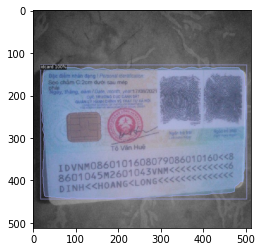

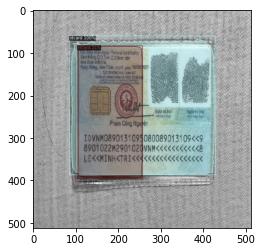

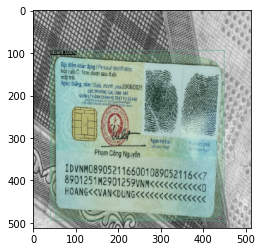

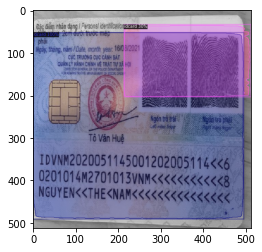

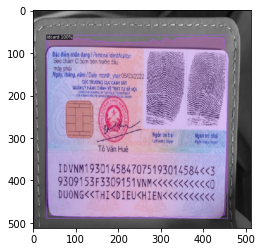

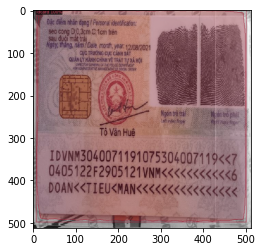

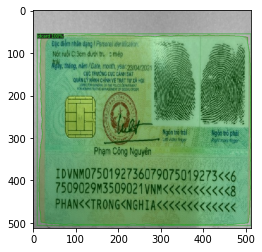

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
%matplotlib inline

meta_test = MetadataCatalog.get(test_name)
data_test = DatasetCatalog.get(test_name)

random.seed(10)
for d in random.sample(data_test, 8):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=meta_test, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Display true label

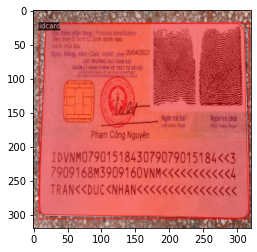

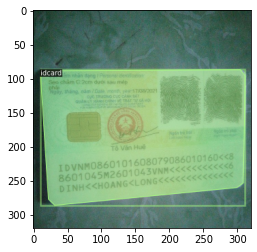

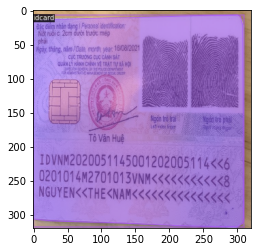

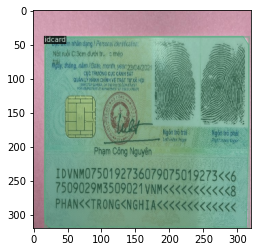

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2
from PIL import Image

random.seed(10)
for d in random.sample(data_test, 8):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta_test, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# predict single image

In [33]:
import cv2
img = cv2.imread("/content/sample_data/image_--130-_JPG.rf.8fda17c98fc234bb2badf54376e3528a.jpg")
img = cv2.resize(img,(640,640))
outputs = predictor(img)
outputs

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 64.1379, 158.8766, 578.5441, 417.7896]])), scores: tensor([0.9980]), pred_classes: tensor([0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]])])}

In [34]:
import numpy as np

# === Extract (only) the mask and box of Hobbes === #
# Find the index of the class we are interested in
# First, convert to numpy array to allow direct indexing
class_ids = np.array(outputs["instances"].pred_classes.cpu())
class_index = np.where(class_ids == 0)  # Find index where class ID is 16
# Use that index to index the array of masks and boxes
mask_tensor = outputs["instances"].pred_masks[class_index]
print(mask_tensor.shape)
mask_tensor

torch.Size([1, 640, 640])


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [35]:
# Convert tensor to numpy array
# hobbes_mask = mask_tensor.cpu()
hobbes_mask = mask_tensor
print("Before:", type(hobbes_mask))
print(hobbes_mask.shape)
hobbes_mask = np.array(hobbes_mask[0])
print("After:", type(hobbes_mask))
print(hobbes_mask.shape)

Before: <class 'torch.Tensor'>
torch.Size([1, 640, 640])
After: <class 'numpy.ndarray'>
(640, 640)


In [36]:
hobbes_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [37]:
# Create blank black background
# The "True" pixels will be converted to white and copied onto the black background
background = np.zeros(hobbes_mask.shape)
background.shape

(640, 640)

In [38]:
# Add white pixels where mask values are True
bin_mask = np.where(hobbes_mask, 255, background).astype(np.uint8)
print(bin_mask.shape)
bin_mask

(640, 640)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

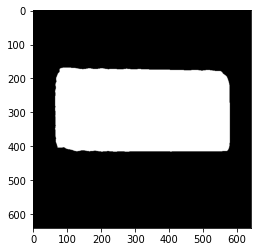

In [39]:

# Show the resulting binary mask
plt.imshow(cv2.cvtColor(bin_mask, cv2.COLOR_BGR2RGB))
# cv2.imwrite("./hong_origin.jpg", img)

BG shape: (640, 640, 3)
Mask shape: (640, 640, 3)


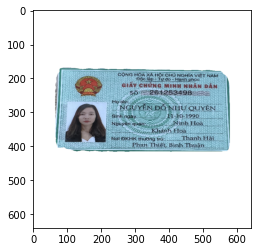

In [40]:
# === Extract pixels using mask === #

# Create blank background
# bg = np.zeros(img.shape)
bg = np.ones(img.shape)*255
print("BG shape:", bg.shape)

# Create mask
mask = np.stack([hobbes_mask, hobbes_mask, hobbes_mask], axis=2)
print("Mask shape:", mask.shape)

# Copy color pixels from the original color image where mask is set
foreground = np.where(mask, img, bg).astype(np.uint8)

# Check out the result
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))

In [ ]:
def canny_edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    """
    image_path: link to image
    blur_ksize: Gaussian kernel size
    threshold1: min threshold 
    threshold2: max threshold
    """
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(img,(blur_ksize,blur_ksize),0)

    img_canny = cv2.Canny(img_gaussian,threshold1,threshold2)

    return img_canny
    
img_canny = canny_edge_detection(bin_mask, 25, 50, 100)

plt.imshow(cv2.cvtColor(img_canny, cv2.COLOR_BGR2RGB))

In [ ]:
corners = cv2.goodFeaturesToTrack(img_canny,4,0.01,100,blockSize = 3)

for corner in corners:
    x,y = corner.ravel()
    print(x, y)
    cv2.circle(img_canny,(int(x),int(y)), 10, (255,255,255), -1)
    
plt.imshow(cv2.cvtColor(img_canny, cv2.COLOR_BGR2RGB))

637.0 522.0
629.0 83.0
24.0 622.0
629.0 622.0
